# Korean News Summary Model

In [2]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import nltk
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
np.random.seed(seed=0)

## Data

In [28]:
data = pd.read_excel("종합 텍스트.xlsx")
print('전체 뉴스 개수 :',(len(data)))

전체 뉴스 개수 : 16983


In [29]:
data.head()

,기사번호,기사카테고리,매체유형,매체구분,매체명,기사대중소,기사본문글자수,발행일시,제목,내용,가독성,정확성,정보성,신뢰성,생성,추출1,추출2,추출3
0,371224146,종합,online,지역지,기호일보,medium,1436,2019-12-18 00:00:00,수사권 조정은 국민인권의 첫걸음,기호일보\n\n전영태 안산단원경찰서 112종합상황실/경위\n전영태 안산단원경찰서 1...,4,4,3,4,현 정부의 핵심 과제인 검경 수사권 조정의 핵심은 검찰의 막강한 권한을 분산해 권력...,검경 수사권 개혁에 대한 문제는 현 정부의 핵심 과제이다.,형사 사법제도의 본질은 경찰·검찰·법원 등 삼권 분립으로 상호 견제와 균형을 이뤄 ...,이번 수사권 조정의 핵심은 검찰의 제왕적 권한을 분산해 타 기관과의 상호 감시와 견...
1,363331583,종합,online,지역지,기호일보,small,898,2019-10-16 00:00:00,인천서 외래 해충 ‘소나무허리노린재’ 발생,최유탁 기자\n\n인천대 배양섭 교수 월미도·인천대 송도캠 정착 개체군 확인\n임업...,4,4,4,4,임업진흥원 외래 무척추동물의 확산 및 변화예측 기술개발 사업단'이 월미도와 인천대학...,임업진흥원 외래 무척추동물의 확산 및 변화예측 기술개발 사업단(단장 배양섭 인천대 ...,15일 사업단에 따르면 외래 산림해충 모니터링과 문헌조사를 병행해 출현 기록이 있는...,국내에서 발생이 확대될 경우 침엽수 비중이 높은 산림생태계 및 가평 등지의 잣 생산...
2,363195607,종합,online,지역지,기호일보,small,747,2019-10-15 00:00:00,"김상희 의원 ""심평원 보험사기 방지 업무 민간 보험사 배불려""",최두환 기자\n\n건강보험 심사평가원의 ‘보험사기 방지’ 업무가 민간보험사의 배를 ...,4,5,4,4,더불어민주당 김상희 의원은 2016년 ‘보험사기방지 특별법’이 제정됨에 따라 ‘보험...,건강보험 심사평가원의 ‘보험사기 방지’ 업무가 민간보험사의 배를 불리며 건보 법에 ...,더불어민주당 김상희(부천 소사) 국회원이 건강보험공단에서 확인한 자료에 따르면 심평...,문제는 이 돈이 건강보험 재정에서 나온다는 것이다.
3,357571415,종합,online,지역지,기호일보,small,757,2019-08-27 00:00:00,"부천시, ‘포도 수확 체험 프로그램’ 운영",부천시는 어린이들이 우리 지역의 포도를 직접 수확해 보는 ‘포도 수확 체험 프로그램...,3,3,3,3,부천시는 포도를 수확하고 맛도 볼 수 있으며 수확한 포도(5kg)을 가져갈 수 있는...,부천시는 어린이들이 우리 지역의 포도를 직접 수확해 보는 ‘포도 수확 체험 프로그램...,"가족 체험에 참여하면 포도 수확, 포도 맛보기 체험을 하고 수확한 포도(5㎏)를 가...","시 관계자는 ""도심에서는 평소 접하기 어려운 포도 수확 체험이 시민들에게 즐겁고 소..."
4,368209875,종합,online,지역지,기호일보,small,767,2019-11-23 13:10:55,"가평군지사협, 어르신 짝쿵 초청 ‘힐링 문화소풍!’",엄건섭 기자\n\n가평군 가평읍지사협은 최근 특화사업인 문화체험 행복나들이 ‘어르신...,5,4,4,4,가평군 가평읍지사협은 복지 사각지대에 있는 지역 어르신들을 대상으로 ‘어르신과 함께...,가평군 가평읍지사협은 최근 특화사업인 문화체험 행복나들이 ‘어르신과 함께하는 힐링 ...,23일 가평읍에 따르면 ‘힐링 문화소풍!’은 복지사각지대에 있는 지역 어르신들을 대...,"내년에도 가평읍 지사협위원들과 협력해 다양한 문화체험의 기회를 제공하도록 하겠다""라..."


In [30]:
data = data[['내용','생성']]
data.head()

,내용,생성
0,기호일보\n\n전영태 안산단원경찰서 112종합상황실/경위\n전영태 안산단원경찰서 1...,현 정부의 핵심 과제인 검경 수사권 조정의 핵심은 검찰의 막강한 권한을 분산해 권력...
1,최유탁 기자\n\n인천대 배양섭 교수 월미도·인천대 송도캠 정착 개체군 확인\n임업...,임업진흥원 외래 무척추동물의 확산 및 변화예측 기술개발 사업단'이 월미도와 인천대학...
2,최두환 기자\n\n건강보험 심사평가원의 ‘보험사기 방지’ 업무가 민간보험사의 배를 ...,더불어민주당 김상희 의원은 2016년 ‘보험사기방지 특별법’이 제정됨에 따라 ‘보험...
3,부천시는 어린이들이 우리 지역의 포도를 직접 수확해 보는 ‘포도 수확 체험 프로그램...,부천시는 포도를 수확하고 맛도 볼 수 있으며 수확한 포도(5kg)을 가져갈 수 있는...
4,엄건섭 기자\n\n가평군 가평읍지사협은 최근 특화사업인 문화체험 행복나들이 ‘어르신...,가평군 가평읍지사협은 복지 사각지대에 있는 지역 어르신들을 대상으로 ‘어르신과 함께...


## Preprocessing

In [31]:
print('내용 열에서 중복을 배제한 유일한 샘플의 수 :', data['내용'].nunique())
print('생성 열에서 중복을 배제한 유일한 샘플의 수 :', data['생성'].nunique())

내용 열에서 중복을 배제한 유일한 샘플의 수 : 16982
추출1 열에서 중복을 배제한 유일한 샘플의 수 : 16982


In [32]:
# text 열에서 중복인 내용이 있다면 중복 제거
data.drop_duplicates(subset=['내용'], inplace=True)
print("전체 샘플수 :", len(data))

전체 샘플수 : 16982


In [33]:
print(data.isnull().sum())

내용    0
생성    0
dtype: int64


In [34]:
# Null 값을 가진 샘플 제거
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 16982


In [35]:
# 한글 불용어
stopword = pd.read_csv('한국어불용어100.txt', sep = "\t", encoding = "utf-8", header=None)
stop_words =  set(stopword[0])
print('불용어 개수 :', len(stop_words))
print(stop_words)

불용어 개수 : 94
{'통하', '보이', '경우', '그리고', '많', '보', '월', '원', '여자', '싶', '이렇', '좀', '수', '더', '생각', '그러', '대하', '있', '앞', '명', '그렇', '그런', '놓', '사실', '때', '말하', '오', '말', '가지', '때문', '점', '두', '어떻', '그것', '이런', '집', '위하', '없', '생각하', '번', '되', '일', '받', '씨', '자신', '모르', '그러나', '데', '또', '안', '그', '사람', '속', '적', '문제', '소리', '들', '크', '내', '사회', '같', '알', '아니', '좋', '년', '어떤', '등', '개', '못하', '나오', '정도', '시키', '나', '다시', '살', '않', '가', '한', '만들', '이', '하나', '지', '잘', '다른', '지금', '시간', '전', '그녀', '중', '우리', '것', '하', '주', '따르'}


In [36]:
# 전처리 함수
def preprocess_sentence(sentence, remove_stopwords = True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열  제거 Ex) my husband (and myself) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = re.sub(r"'s\b","",sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[.,!?\"':;~()]", " ", sentence) # 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub("r'[^ ㄱ-ㅣ가-힣A-Za-z]", " ", sentence)
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stop_words if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [37]:
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_summary = 'Great way to start (or finish) the day!!!'
print(preprocess_sentence(temp_text))
print(preprocess_sentence(temp_summary, 0))

everything bought was great infact ordered twice and the third ordered wasfor my mother and father
great way to start the day


In [38]:
# Text 열 전처리
clean_text = []
for s in data['내용']:
    clean_text.append(preprocess_sentence(s))
clean_text[:5]

['기호일보 전영태 안산단원경찰서 112종합상황실/경위 전영태 안산단원경찰서 112종합상황실 검경 수사권 개혁에 대한 문제는 정부의 핵심 과제이다 대통령의 사법농단을 수사하느라 사법개혁특별위원회 구성이 늦어져 최근에 논의되고 있다 수사권 조정 지연은 제1야당의 소위원회 구성 비협조와 검찰의 미온적 태도로 현재까지 협상 중이다 그래서 대통령과 4당의 당대표 국회의원들이 수사권 조정을 통해 국민의 인권을 증진하고 검찰 권력의 폐해를 예방해 제왕적 권력을 분산하자는 것이다 그런데 검찰은 최근에 공수처법과 검경 수사권 조정안 등이 포함된 ‘패스트 트랙’ 국회 본회의 처리가 임박하자 검찰 간부들이 여야 의원을 불문하고 개별 접촉해 검찰개혁 법안 수정에 총력을 기울이는 것으로 알려졌다 고사성어 득롱망촉이라는 말이 있다 인간의 욕심은 한이 없어 권력에 한번 중독이 되면 마약과 같아서 끊임없이 쟁취하고 자신의 것을 지키기 위해 사람과도 타협하지 않는다고 한다 지금의 검찰이 그렇다 중국의 시진핑은 권력은 부패를 초래하고 절대 권력은 반드시 부패한다 라고 말했고 다산 정약용도 나라를 망하게 하는 것은 외침이 아니라 권력의 부정부패에 의한 민심의 이반이라고 경고했다 검찰의 모습은 한마디로 우이독경이다 국민의 대표인 국회의원과 대통령이 신속처리법안 개정의 보완이 필요하다고 하는데 검찰만이 아니라고 얘기하는 모습이 너무나 안쓰럽다 최근 검찰개혁에 대한 국민의 여론조사와 5월에 발간한 백년하청 검찰개혁 보고서에 의하면 검찰을 개혁해야 한다는 여론이 75% 이상 나왔다 이번에도 검찰개혁이 무산되면 무소불위의 검찰 공화국이 것이다 우리는 노무현 정부의 검찰과의 토론회나 정부의 수사권 조정 과정에서 검찰이 얼마나 힘이 센지 여실히 보았다 형사 사법제도의 본질은 경찰·검찰·법원 삼권 분립으로 상호 견제와 균형을 이뤄 대등한 관계에서 불합리한 수사구조를 개선하고 국민의 인권을 강화하는 것이다 하지만 우리의 현실은 검찰이 수사권 수사 지휘권 수사 종결권 영장 청구권 제왕적 권한을 갖고 있어 권력

In [39]:
# Summary 열 전처리
clean_summary = []
for s in data['생성']:
    clean_summary.append(preprocess_sentence(s, 0))
clean_summary[:5]

['정부의 핵심 과제인 검경 수사권 조정의 핵심은 검찰의 막강한 권한을 분산해 권력의 견제와 균형을 이루어 불합리한 수사구조를 개선하고 국민의 인권을 강화하는 것이다',
 '임업진흥원 외래 무척추동물의 확산 변화예측 기술개발 사업단 월미도와 인천대학교 송도캠퍼스 등에서 소나무의 어린 솔방울을 집중적으로 가해하는 외래 해충인 소나무허리노린재 개체군이 정착한 것을 확인했으며 국내에서 발생이 늘어날 경우 침엽수 비중이 높은 산림생태계 가평 등지의 생산에 심각한 피해가 우려된다',
 '더불어민주당 김상희 의원은 2016년 ‘보험사기방지 특별법’이 제정됨에 따라 ‘보험사기 방지’ 업무를 수행해 심평원이 건강보험 재정으로 민간보험사의 이익을 활성화하는 역할을 수행하고 있다고 비판했다',
 '부천시는 포도를 수확하고 맛도 있으며 수확한 포도을 가져갈 있는 포도 수확 체험 프로그램을 운영하여 시민들에게 추억을 남기고 농산물에 대한 신뢰를 높이는 기회로 삼고 있다',
 '가평군 가평읍지사협은 복지 사각지대에 있는 지역 어르신들을 대상으로 ‘어르신과 함께하는 힐링 문화소풍’을 진행했고 내년에도 가평읍 지사협위원들과 협력해 다양한 문화체험의 시간을 가질 계획이라고 말했다']

In [40]:
data['내용'] = clean_text
data['생성'] = clean_summary

In [41]:
# 길이가 공백인 샘플은 NULL 값으로 변환
data.replace('', np.nan, inplace=True)
print(data.isnull().sum())

내용    0
생성    0
dtype: int64


In [42]:
data.dropna(axis = 0, inplace = True)
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 16982


텍스트의 최소 길이 : 6
텍스트의 최대 길이 : 445
텍스트의 평균 길이 : 205.78453656813096
요약의 최소 길이 : 6
요약의 최대 길이 : 73
요약의 평균 길이 : 25.947473795783772


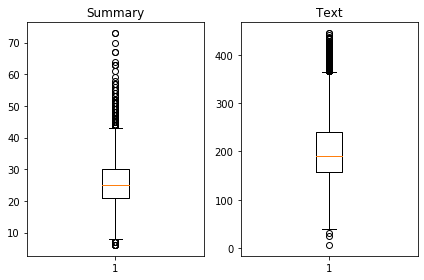

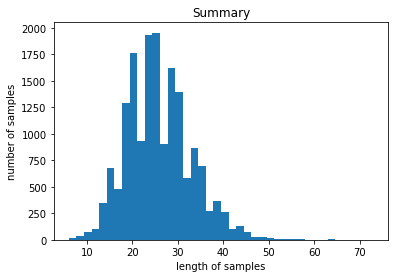

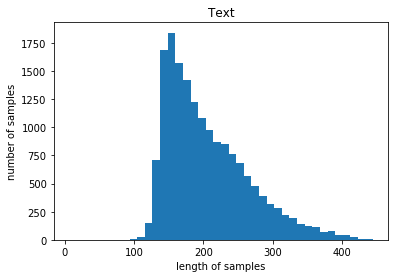

In [43]:
# 길이 분포 출력
text_len = [len(s.split()) for s in data['내용']]
summary_len = [len(s.split()) for s in data['생성']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(summary_len)
plt.title('Summary')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title('Text')
plt.tight_layout()
plt.show()

plt.title('Summary')
plt.hist(summary_len, bins=40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Text')
plt.hist(text_len, bins=40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [44]:
text_max_len = 300
summary_max_len = 40

In [45]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [46]:
below_threshold_len(text_max_len, data['내용'])

전체 샘플 중 길이가 300 이하인 샘플의 비율: 0.916676480979861


In [47]:
below_threshold_len(summary_max_len, data['생성'])

전체 샘플 중 길이가 40 이하인 샘플의 비율: 0.9684371687669296


In [48]:
data = data[data['내용'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['생성'].apply(lambda x: len(x.split()) <= summary_max_len)]
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 15077


In [49]:
data.head()

,내용,생성
1,최유탁 기자 인천대 배양섭 교수 월미도·인천대 송도캠 정착 개체군 확인 임업진흥원 ...,임업진흥원 외래 무척추동물의 확산 변화예측 기술개발 사업단 월미도와 인천대학교 송도...
2,최두환 기자 건강보험 심사평가원의 ‘보험사기 방지’ 업무가 민간보험사의 배를 불리며...,더불어민주당 김상희 의원은 2016년 ‘보험사기방지 특별법’이 제정됨에 따라 ‘보험...
3,부천시는 어린이들이 지역의 포도를 직접 수확해 보는 ‘포도 수확 체험 프로그램’을 ...,부천시는 포도를 수확하고 맛도 있으며 수확한 포도을 가져갈 있는 포도 수확 체험 프...
4,엄건섭 기자 가평군 가평읍지사협은 최근 특화사업인 문화체험 행복나들이 ‘어르신과 함...,가평군 가평읍지사협은 복지 사각지대에 있는 지역 어르신들을 대상으로 ‘어르신과 함께...
5,박지훈 기자 전남도 6·25전쟁 69주년 기념식 유공자 22명 표창 6ㆍ25전쟁 제...,전남도와 목포시는 25일 목포문화예술회관에서 호국영령을 기리고 참전유공자의 자긍심 ...


In [50]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['내용'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['생성'].apply(lambda x : x + ' eostoken')
data.head()

,내용,생성,decoder_input,decoder_target
1,최유탁 기자 인천대 배양섭 교수 월미도·인천대 송도캠 정착 개체군 확인 임업진흥원 ...,임업진흥원 외래 무척추동물의 확산 변화예측 기술개발 사업단 월미도와 인천대학교 송도...,sostoken 최유탁 기자 인천대 배양섭 교수 월미도·인천대 송도캠 정착 개체군 ...,임업진흥원 외래 무척추동물의 확산 변화예측 기술개발 사업단 월미도와 인천대학교 송도...
2,최두환 기자 건강보험 심사평가원의 ‘보험사기 방지’ 업무가 민간보험사의 배를 불리며...,더불어민주당 김상희 의원은 2016년 ‘보험사기방지 특별법’이 제정됨에 따라 ‘보험...,sostoken 최두환 기자 건강보험 심사평가원의 ‘보험사기 방지’ 업무가 민간보험...,더불어민주당 김상희 의원은 2016년 ‘보험사기방지 특별법’이 제정됨에 따라 ‘보험...
3,부천시는 어린이들이 지역의 포도를 직접 수확해 보는 ‘포도 수확 체험 프로그램’을 ...,부천시는 포도를 수확하고 맛도 있으며 수확한 포도을 가져갈 있는 포도 수확 체험 프...,sostoken 부천시는 어린이들이 지역의 포도를 직접 수확해 보는 ‘포도 수확 체...,부천시는 포도를 수확하고 맛도 있으며 수확한 포도을 가져갈 있는 포도 수확 체험 프...
4,엄건섭 기자 가평군 가평읍지사협은 최근 특화사업인 문화체험 행복나들이 ‘어르신과 함...,가평군 가평읍지사협은 복지 사각지대에 있는 지역 어르신들을 대상으로 ‘어르신과 함께...,sostoken 엄건섭 기자 가평군 가평읍지사협은 최근 특화사업인 문화체험 행복나들...,가평군 가평읍지사협은 복지 사각지대에 있는 지역 어르신들을 대상으로 ‘어르신과 함께...
5,박지훈 기자 전남도 6·25전쟁 69주년 기념식 유공자 22명 표창 6ㆍ25전쟁 제...,전남도와 목포시는 25일 목포문화예술회관에서 호국영령을 기리고 참전유공자의 자긍심 ...,sostoken 박지훈 기자 전남도 6·25전쟁 69주년 기념식 유공자 22명 표창...,전남도와 목포시는 25일 목포문화예술회관에서 호국영령을 기리고 참전유공자의 자긍심 ...


In [52]:
encoder_input = np.array(data['내용'])
decoder_input = np.array(data['decoder_input'])
decoder_target = np.array(data['decoder_target'])

## Split Data

In [53]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[ 1687  7851  8560 ...  9845 10799  2732]


In [54]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [55]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :',n_of_val)

테스트 데이터의 수 : 3015


In [56]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

In [57]:
print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

훈련 데이터의 개수 : 12062
훈련 레이블의 개수 : 12062
테스트 데이터의 개수 : 3015
테스트 레이블의 개수 : 3015


## Encoding

In [58]:
src_tokenizer = Tokenizer()
src_tokenizer.fit_on_texts(encoder_input_train)

In [59]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 437531
등장 빈도가 6번 이하인 희귀 단어의 수: 397918
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 39613
단어 집합에서 희귀 단어의 비율: 90.94624152345777
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 26.290858597821437


In [63]:
src_vocab = 300000
src_tokenizer = Tokenizer(num_words = src_vocab) 
src_tokenizer.fit_on_texts(encoder_input_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

AttributeError: 'int' object has no attribute 'lower'

In [64]:
print(encoder_input_train[:3])

[[157, 3009, 730, 185, 231, 52, 6711, 2328, 2135, 3506, 3095, 13, 1993, 206, 955, 239, 648, 17, 4286, 393, 202, 33, 7540, 405, 108, 1993, 1082, 49, 7541, 1041, 258, 39, 58, 28, 2158, 785, 6305, 7542, 2102, 3506, 1555, 1063, 231, 52, 1230, 3506, 1555, 1905, 6435, 1803, 155, 1461, 1699, 1611, 1167, 36, 1512, 3047, 3228, 58, 49, 3506, 1555, 781, 14, 5050, 79, 1750, 407, 3507, 49, 5892, 393, 3810, 73, 355, 14, 1535, 7366, 1751, 288, 7543, 1, 2939, 8, 9], [562, 38, 562, 63, 122, 7899, 14, 5665, 17, 5666, 1817, 2329, 62, 4710, 2219, 840, 1556, 2434, 3, 689, 754, 3747, 26, 6436, 754, 5667, 397, 69, 1648, 3508, 142, 7022, 642, 44, 3048, 29, 558, 5311, 5312, 1648, 3096, 2, 2434, 677, 1569, 2284, 1536, 6849, 63, 188, 238, 46, 2136, 5051, 43, 397, 1919, 298, 2711, 5313, 754, 3747, 4483, 103, 2136, 4560, 6712, 6437, 147, 1687, 615, 2567, 7201, 4427, 1687, 1525, 14, 223, 509, 2, 43, 4633, 2220, 19, 2], [627, 1, 4073, 4711, 6036, 6713, 28, 455, 5668, 6306, 2406, 2137, 5415, 4789, 5668, 5415, 6306, 1

In [65]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [66]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 437532
등장 빈도가 5번 이하인 희귀 단어의 수: 391422
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 46110
단어 집합에서 희귀 단어의 비율: 89.46134225610926
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 24.514040743471604


In [67]:
tar_vocab = 40000
tar_tokenizer = Tokenizer(num_words = tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

In [68]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

In [69]:
print(decoder_input_train[:5])

[[3, 167, 31685, 13498, 2720, 698, 31686, 187, 39193, 240, 57, 6019, 17448, 2298, 31687, 1771, 3446, 2953, 9, 1705, 218, 812, 234, 576, 13, 4522, 419, 209, 35, 7792, 13007, 20512, 402, 23265, 114, 1705, 1037, 46, 6608, 1075, 307, 42, 60, 29, 31685, 10380, 15267, 2158, 738, 6345, 8548, 7972, 2146, 12130, 3446, 1511, 1038, 240, 57, 1201, 3446, 1511, 1981, 39194, 5909, 1805, 23266, 180, 31688, 24938, 1547, 14039, 35092, 1721, 8965, 1737, 1311, 38, 31685, 1492, 3351, 3759, 60, 15268, 17448, 46, 3446, 1511, 826, 31685, 12, 4947, 7973, 88, 1918, 399, 14040, 3447, 46, 6219, 419, 3909, 12568, 75, 361, 24939, 39195, 12, 1512, 7443, 1833, 10676, 364, 7444, 39196, 1, 3448, 14, 15], [3, 668, 45, 668, 65, 10991, 137, 7793, 12, 35093, 35094, 5790, 14647, 13, 5378, 1931, 2228, 64, 31689, 4725, 2277, 16692, 31689, 840, 1480, 2663, 5, 645, 790, 4063, 27, 8344, 6609, 790, 5676, 426, 76, 29055, 1576, 10992, 3449, 12131, 107, 29055, 31690, 5910, 10992, 714, 31689, 49, 26802, 3491, 36, 478, 4948, 39197, 52

In [70]:
print(decoder_target_train[:5])

[[2298, 3446, 2953, 9, 29, 1771, 31685, 14343, 17323, 13498, 2720, 2748, 3446, 1511, 6643, 698, 5909, 39193, 240, 9022, 4522, 209, 35, 7792, 402, 23265, 1705, 2830, 46, 6608, 1978, 42, 4], [275, 10992, 1576, 3474, 160, 2, 4], [6747, 4350, 12132, 35878, 550, 24940, 26806, 18390, 27431, 18389, 3859, 1627, 6020, 29047, 4804, 4], [16696, 1224, 63, 35096, 21815, 6, 203, 5795, 4753, 857, 191, 2422, 106, 6222, 21815, 6, 377, 17450, 501, 11202, 377, 13186, 51, 17394, 166, 4], [2590, 8153, 5796, 26808, 19386, 7625, 20062, 26811, 11729, 24, 1635, 6, 4235, 19387, 755, 4236, 414, 1559, 4725, 378, 691, 4]]


## Remove Empty Samples

In [71]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

In [72]:
print('삭제할 훈련 데이터의 개수 :',len(drop_train))
print('삭제할 테스트 데이터의 개수 :',len(drop_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0


In [73]:
encoder_input_train = np.delete(encoder_input_train, drop_train, axis=0)
decoder_input_train = np.delete(decoder_input_train, drop_train, axis=0)
decoder_target_train = np.delete(decoder_target_train, drop_train, axis=0)

encoder_input_test = np.delete(encoder_input_test, drop_test, axis=0)
decoder_input_test = np.delete(decoder_input_test, drop_test, axis=0)
decoder_target_test = np.delete(decoder_target_test, drop_test, axis=0)

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

훈련 데이터의 개수 : 12062
훈련 레이블의 개수 : 12062
테스트 데이터의 개수 : 3015
테스트 레이블의 개수 : 3015


## Padding

In [74]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen = text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen = text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen = summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen = summary_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen = summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen = summary_max_len, padding='post')

## Seq2Seq + Attention Summary Model

In [75]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [76]:
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

In [77]:
# 디코더
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences = True, return_state = True, dropout = 0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state = [state_h, state_c])

In [78]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation = 'softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 300, 128)     38400000    input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 300, 256), ( 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [79]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/thushv89/attention_keras/master/src/layers/attention.py", filename="attention.py")
from attention import AttentionLayer

In [80]:
# 어텐션 층(어텐션 함수)
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis = -1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 300, 128)     38400000    input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 300, 256), ( 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

In [81]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [82]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 2)
history = model.fit(x = [encoder_input_train, decoder_input_train], y = decoder_target_train, \
          validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size = 256, callbacks=[es], epochs = 50)

Train on 12062 samples, validate on 3015 samples
Epoch 1/50
  256/12062 [..............................] - ETA: 3:01:39WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: 


ResourceExhaustedError:  OOM when allocating tensor with shape[256,40,40000] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu
	 [[node model_1/dense_1/sub (defined at <ipython-input-82-ee4ec6f87319>:4) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_distributed_function_15807]

Function call stack:
distributed_function


In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## Evaluation

In [ ]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [ ]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

In [ ]:
# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)
# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [ ]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [ ]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if(sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

In [ ]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if(i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

In [ ]:
for i in range(500, 1000):
    print("원문 : ",seq2text(encoder_input_test[i]))
    print("실제 요약문 :",seq2summary(decoder_input_test[i]))
    print("예측 요약문 :",decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")